In [58]:
# utils
import random
import tempfile
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from utilsforecast.plotting import plot_series

# main module
from mlforecast import MLForecast
# transforms
from mlforecast.lag_transforms import ExpandingMean, RollingMean, ExponentiallyWeightedMean
from mlforecast.target_transforms import Differences, LocalStandardScaler
from numba import njit
from window_ops.rolling import rolling_mean
# model
import lightgbm as lgb
from mlforecast.lgb_cv import LightGBMCV
# metric
from utilsforecast.losses import rmse

# data

In [46]:
# TODO 未使用
# async def load_download_data():
#     """
#     data download and filter: M4 hourly
#     """
#     from datasetsforecast.m4 import M4
#     await M4.async_download()
#     df, *_ = M4.load('data', 'Hourly')
#     # data filter
#     uids = df['unique_id'].unique()
#     random.seed(0)
#     sample_uids = random.choices(uids, k=4)
#     df = df[df['unique_id'].isin(sample_uids)].reset_index(drop=True)
#     df['ds'] = df['ds'].astype('int64')
    
#     return df


def load_data(num_series = 4):
    """
    data read and filter
    """
    # data read
    df = pd.read_parquet("https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet")
    # print(df.head())
    # print(df["unique_id"].value_counts())
    
    # data filter
    uids = df['unique_id'].unique()
    random.seed(0)
    sample_uids = random.choices(uids, k = num_series)
    df = df[df['unique_id'].isin(sample_uids)].reset_index(drop = True)
    df['ds'] = df['ds'].astype('int64')
    # print(df["unique_id"].value_counts())
    
    return df

df = load_data(num_series = 4)
print(df.head())
print()
print(df.shape)
print()
print(df["unique_id"].value_counts())

  unique_id  ds     y
0      H196   1  11.8
1      H196   2  11.4
2      H196   3  11.1
3      H196   4  10.8
4      H196   5  10.6

(4032, 3)

H196    1008
H256    1008
H381    1008
H413    1008
Name: unique_id, dtype: int64


# EDA

## 周期分析

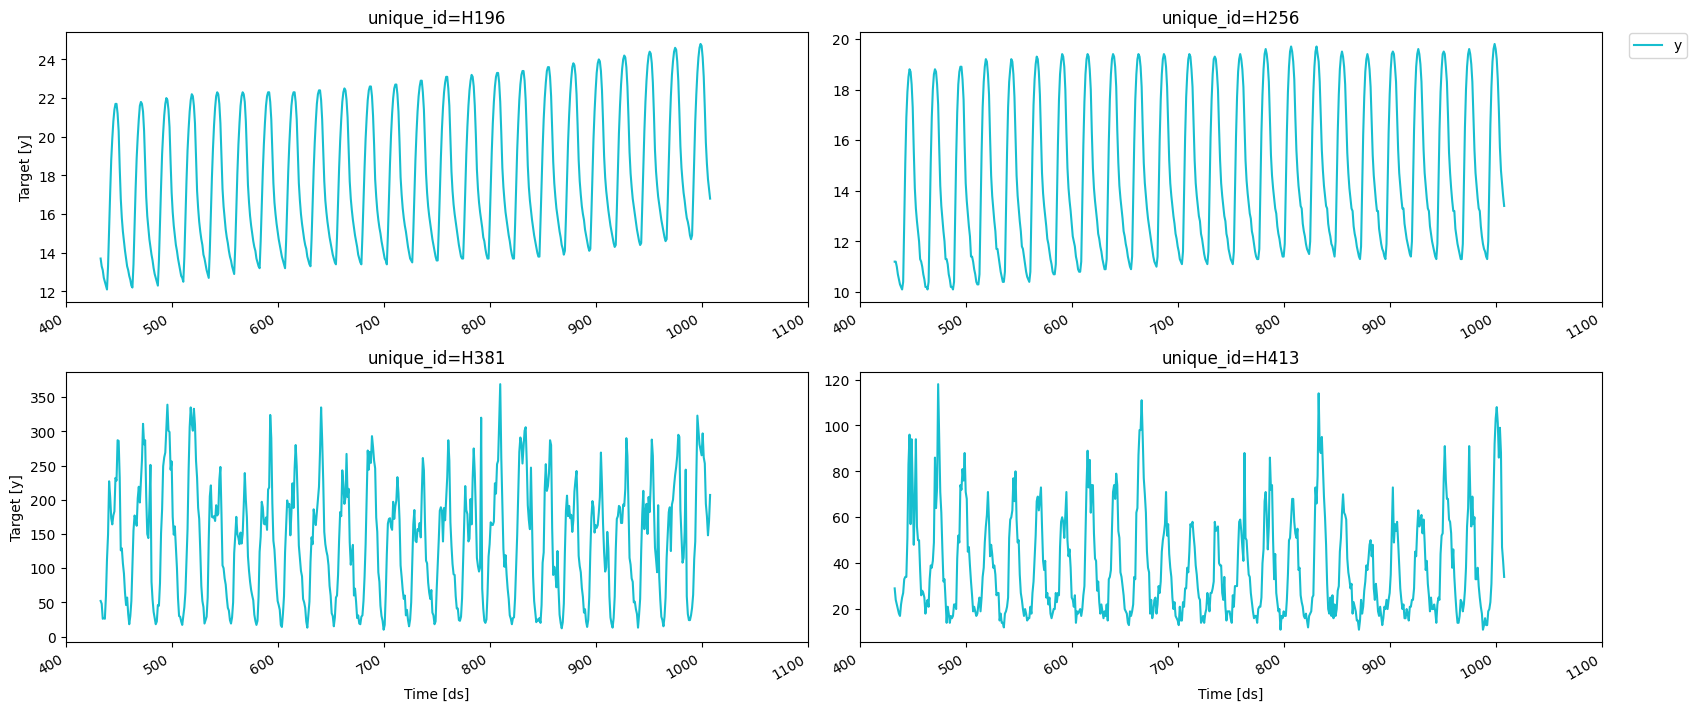

In [40]:
# 模型的周期为 1day = 24hour
fig = plot_series(df, max_insample_length = 24*24)
# fig.savefig('index.png', bbox_inches='tight')
fig

## 去除季节性因素

In [41]:
# subtract seasonality using difference(remove seasonality)
fcst = MLForecast(
    models = [],  # not interested in modeling
    freq = 1,  # series have integer timestamps, so just add 1 in every timestamp
    target_transforms = [Differences([24])],
)
prep = fcst.preprocess(df)
print(prep.head())
print()
print(prep.shape)
print()
print(prep["unique_id"].value_counts())

   unique_id  ds    y
24      H196  25  0.3
25      H196  26  0.3
26      H196  27  0.1
27      H196  28  0.2
28      H196  29  0.2

(3936, 3)

H196    984
H256    984
H381    984
H413    984
Name: unique_id, dtype: int64


## 平稳序列

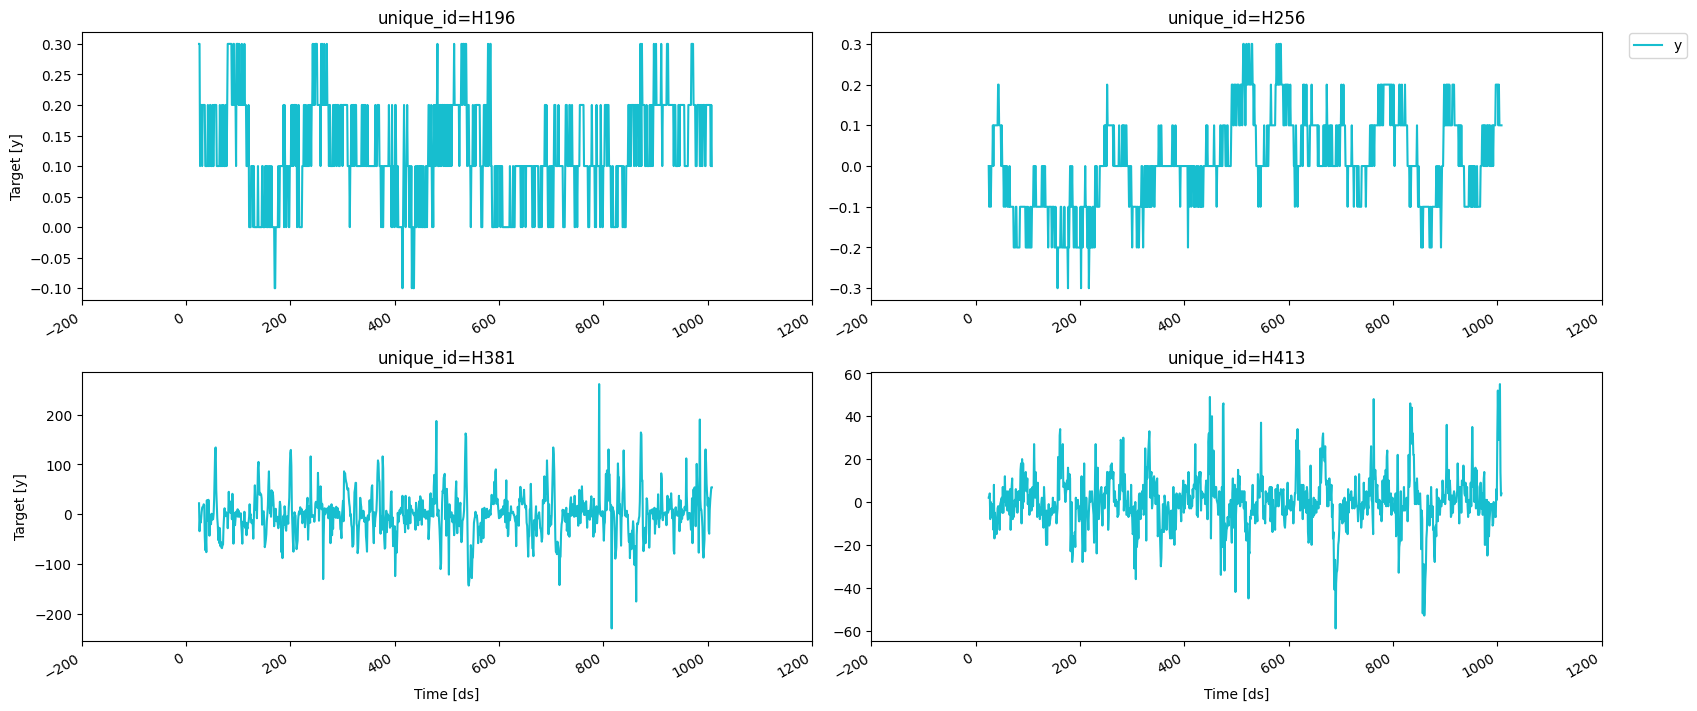

In [43]:
# after subtacted the lag 24 from each value
fig = plot_series(prep)
fig

# feature engine

## add lags features

In [53]:
# 新增两个 lag 特征: lag1, lag24
fcst = MLForecast(
    models = [],
    freq = 1,
    lags = [1, 24],
    target_transforms=[Differences([24])],
)
prep = fcst.preprocess(df)
print(prep.head())
print()
print(prep.shape)
print()
print(prep["unique_id"].value_counts())

   unique_id  ds    y  lag1  lag24
48      H196  49  0.1   0.1    0.3
49      H196  50  0.1   0.1    0.3
50      H196  51  0.2   0.1    0.1
51      H196  52  0.1   0.2    0.2
52      H196  53  0.1   0.1    0.2

(3840, 5)

H196    960
H256    960
H381    960
H413    960
Name: unique_id, dtype: int64


In [54]:
# lags features 与预测变量的相关性
prep[["lag1", "lag24", "y"]].corr()

,lag1,lag24,y
lag1,1.000000,-0.103819,0.622531
lag24,-0.103819,1.000000,-0.234268
y,0.622531,-0.234268,1.000000


## Lag transforms

In [55]:
@njit
def rolling_mean_48(x):
    return rolling_mean(x, window_size = 48)

fcst = MLForecast(
    models = [],
    freq = 1,
    target_transforms = [Differences([24])],
    lag_transforms = {
        1: [ExpandingMean()],
        24: [
            RollingMean(window_size = 48), 
            rolling_mean_48
        ]
    },
)
prep = fcst.preprocess(df)
print(prep.head())
print()
print(prep.shape)
print()
print(prep["unique_id"].value_counts())

   unique_id   ds    y  expanding_mean_lag1  rolling_mean_lag24_window_size48  \
95      H196   96  0.1             0.174648                          0.150000   
96      H196   97  0.3             0.173611                          0.145833   
97      H196   98  0.3             0.175342                          0.141667   
98      H196   99  0.3             0.177027                          0.141667   
99      H196  100  0.3             0.178667                          0.141667   

    rolling_mean_48_lag24  
95               0.150000  
96               0.145833  
97               0.141667  
98               0.141667  
99               0.141667  

(3652, 6)

H196    913
H256    913
H381    913
H413    913
Name: unique_id, dtype: int64


## Date features

In [56]:
def hour_index(times):
    return times % 24

fcst = MLForecast(
    models = [],
    freq = 1,
    target_transforms = [Differences([24])],
    date_features = [hour_index],
)
prep = fcst.preprocess(df)
print(prep.head())
print()
print(prep.shape)
print()
print(prep["unique_id"].value_counts())

   unique_id  ds    y  hour_index
24      H196  25  0.3           1
25      H196  26  0.3           2
26      H196  27  0.1           3
27      H196  28  0.2           4
28      H196  29  0.2           5

(3936, 4)

H196    984
H256    984
H381    984
H413    984
Name: unique_id, dtype: int64


## target transformations

In [57]:
fcst = MLForecast(
    models = [],
    freq = 1,
    lags = [1],
    target_transforms = [LocalStandardScaler()],
)
prep = fcst.preprocess(df)
print(prep.head())
print()
print(prep.shape)
print()
print(prep["unique_id"].value_counts())

  unique_id  ds         y      lag1
1      H196   2 -1.493026 -1.383286
2      H196   3 -1.575331 -1.493026
3      H196   4 -1.657635 -1.575331
4      H196   5 -1.712505 -1.657635
5      H196   6 -1.794810 -1.712505

(4028, 4)

H196    1007
H256    1007
H381    1007
H413    1007
Name: unique_id, dtype: int64


# model training

In [65]:
def hour_index(times):
    return times % 24

# lightgbm params
lgb_params = {
    "verbosity": -1,
    "num_leaves": 512,
}
# mmodel build
fcst = MLForecast(
    models = {
        "avg": lgb.LGBMRegressor(**lgb_params),
        "q75": lgb.LGBMRegressor(**lgb_params, objective = "quantile", alpha = 0.75),
        "q25": lgb.LGBMRegressor(**lgb_params, objective = "quantile", alpha = 0.25)
    },
    freq = 1,
    target_transforms = [
        Differences([24]),
        LocalStandardScaler()
    ],
    lags = [1, 24],
    lag_transforms = {
        1: [ExpandingMean()],
        24: [RollingMean(window_size = 48)],
    },
    date_features = [hour_index],
)
fcst.fit(df)

MLForecast(models=[avg, q75, q25], freq=1, lag_features=['lag1', 'lag24', 'expanding_mean_lag1', 'rolling_mean_lag24_window_size48'], date_features=[<function hour_index at 0x0000016C691DEEE0>], num_threads=1)

# model forecasting

In [66]:
preds = fcst.predict(h = 48)
preds

,unique_id,ds,avg,q75,q25
0,H196,1009,16.297432,16.357683,16.296391
1,H196,1010,15.895074,15.938675,15.894570
2,H196,1011,15.708899,15.722171,15.665812
3,H196,1012,15.447685,15.452143,15.328285
4,H196,1013,15.015225,15.069203,14.933016
...,...,...,...,...,...
187,H413,1052,89.044726,97.203846,53.388045
188,H413,1053,61.097437,83.278472,43.516083
189,H413,1054,35.737651,52.385830,8.527155
190,H413,1055,30.442245,48.711701,7.083264


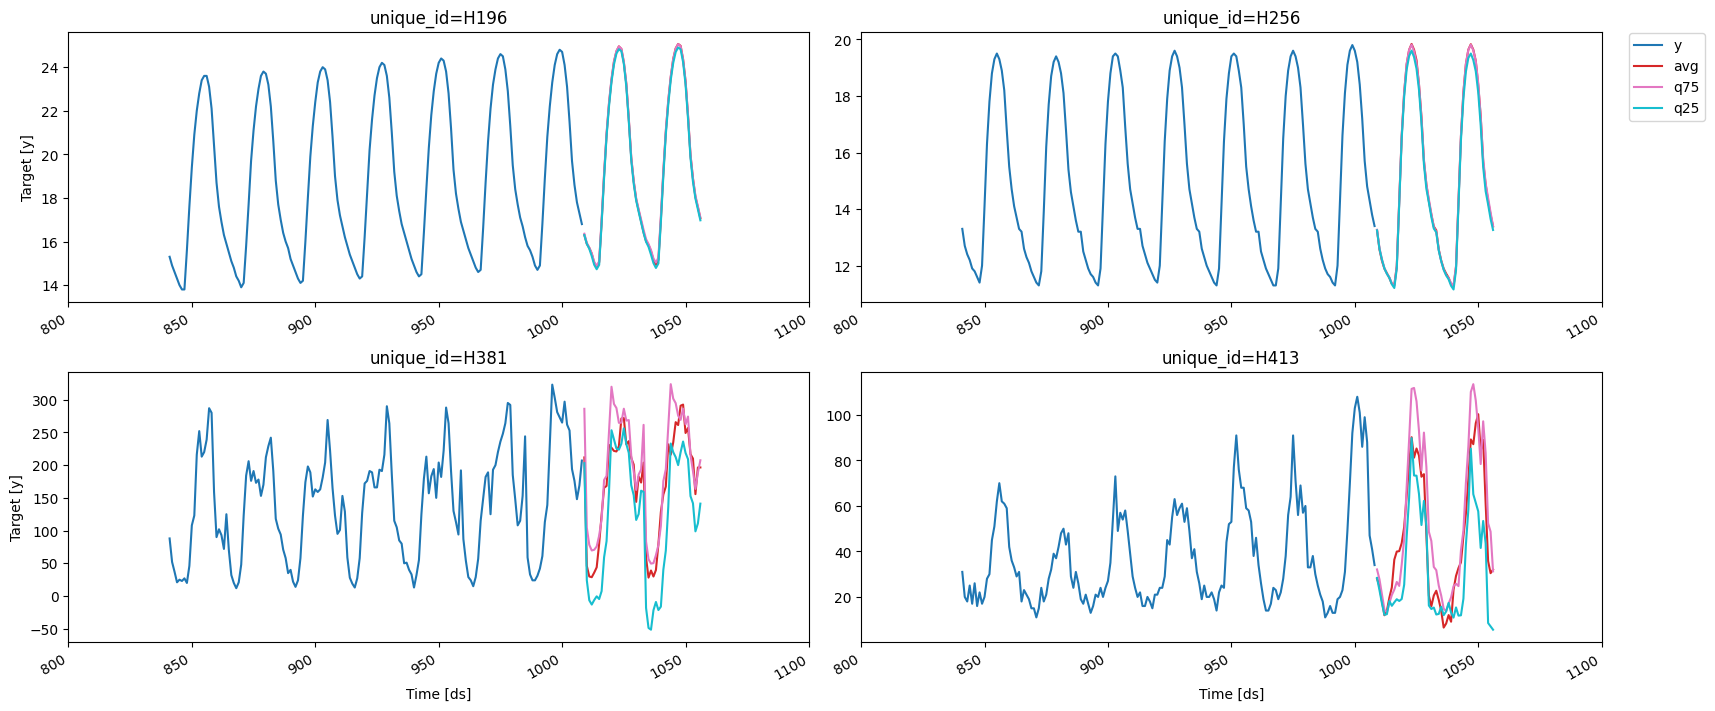

In [67]:
fig = plot_series(df, preds, max_insample_length = 24 * 7)
fig

# model save and load

In [71]:
with tempfile.TemporaryDirectory() as tmpdir:
    model_dir = Path(tmpdir) / "mlforecast"
    # save
    fcst.save(model_dir)
    # load
    fcst2 = MLForecast.load(model_dir)
    # predict
    preds2 = fcst2.predict(h = 48)
    pd.testing.assert_frame_equal(preds, preds2)

# update series's value

In [75]:
# navie model
from sklearn.base import BaseEstimator
class Navie(BaseEstimator):
    
    def fit(self, X, y):
        return self
    
    def predict(self, X):
        return X["lag1"]

# model
fcst = MLForecast(
    models = [Navie()],
    freq = 1,
    lags = [1, 2, 3],
)
fcst.fit(df)
pred1 = fcst.predict(h = 1)
print(pred1)

  unique_id    ds  Navie
0      H196  1009   16.8
1      H256  1009   13.4
2      H381  1009  207.0
3      H413  1009   34.0


In [76]:
# new values
new_values = pd.DataFrame({
    "unique_id": ["H196", "H256"],
    "ds": [1009, 1009],
    "y": [17.0, 14.0],
})
fcst.update(new_values)
pred_new = fcst.predict(h = 1)
print(pred_new)

  unique_id    ds  Navie
0      H196  1010   17.0
1      H256  1010   14.0
2      H381  1009  207.0
3      H413  1009   34.0


# model evaluation

## TODO cross validation

### example 1

In [78]:
# date feature
def hour_index(times):
    return times % 24

# lgb params
lgb_params = {
    "verbosity": -1,
    "num_leaves": 512,
}

# model
fcst = MLForecast(
    models = lgb.LGBMRegressor(**lgb_params),
    freq = 1,
    target_transforms = [Differences([24])],
    lags = [1, 24],
    lag_transforms = {
        1: [ExpandingMean()],
        24: [RollingMean(window_size = 48)],
    },
    date_features = [hour_index],
)

# cross validation
cv_result = fcst.cross_validation(
    df,
    n_windows = 4,  # number of models to train/split to perform
    h = 48,  # length of the validation set in each window
)
cv_result

,unique_id,ds,cutoff,y,LGBMRegressor
0,H196,817,816,15.3,15.383165
1,H196,818,816,14.9,14.923219
2,H196,819,816,14.6,14.667834
3,H196,820,816,14.2,14.275964
4,H196,821,816,13.9,13.973491
...,...,...,...,...,...
763,H413,1004,960,99.0,65.644823
764,H413,1005,960,88.0,71.717097
765,H413,1006,960,47.0,76.704377
766,H413,1007,960,41.0,53.446638


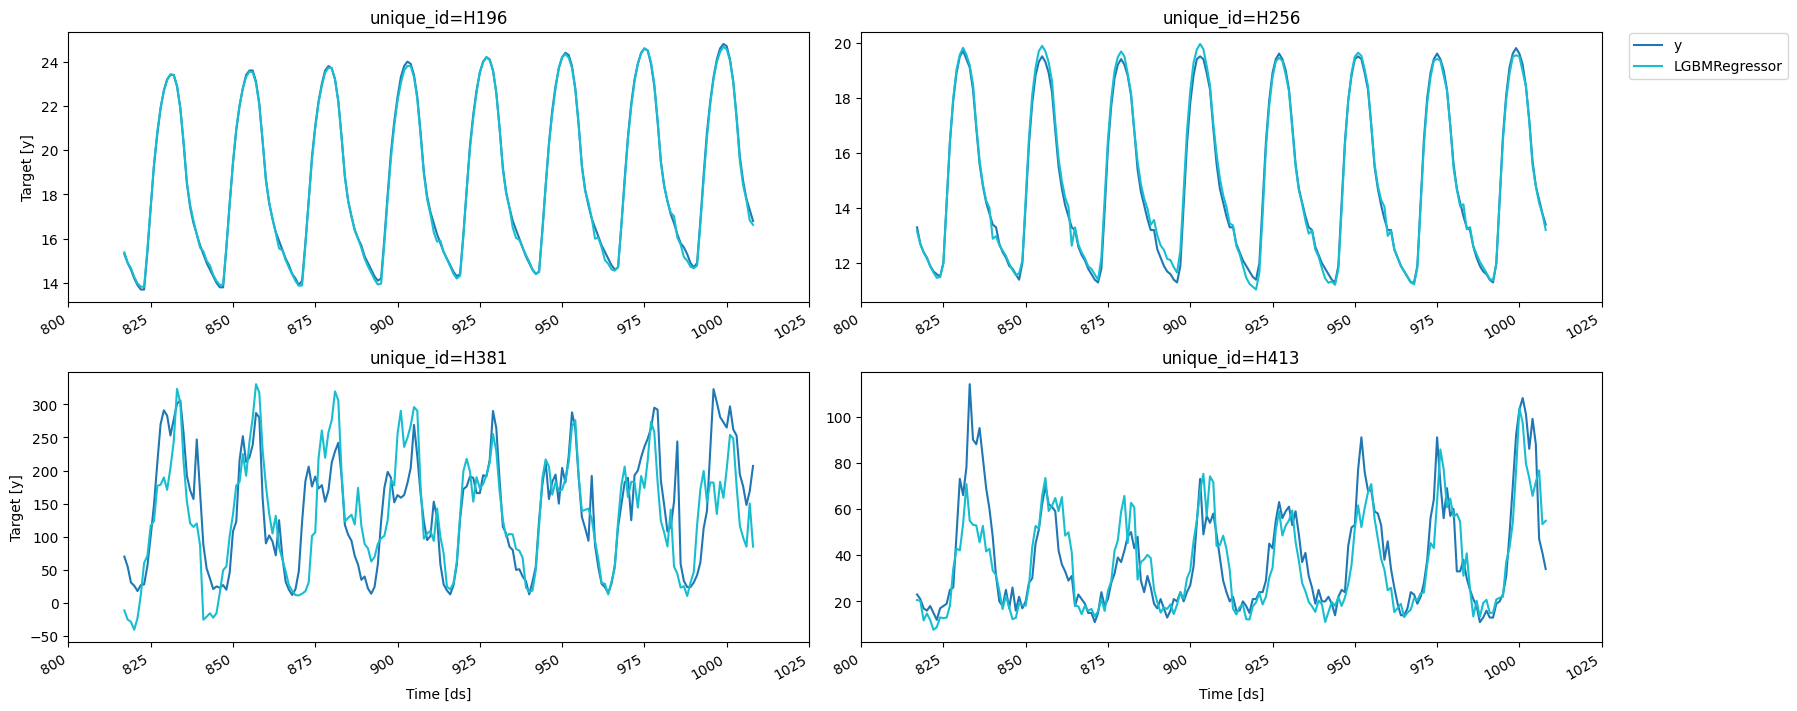

In [79]:
fig = plot_series(forecasts_df = cv_result.drop(columns='cutoff'))
fig

In [82]:
# 计算每个分割的 RMSE
def evaluate_cv(df):
    return rmse(df, models = ["LGBMRegressor"], id_col = "cutoff").set_index("cutoff")

split_rmse = evaluate_cv(cv_result)
print(f"split_rmse:\n{split_rmse}")


# 计算所有分割的 RMSE 均值
print(f"\nsplit_rmse_mean:\n{split_rmse.mean()}")

split_rmse:
        LGBMRegressor
cutoff               
816         29.418172
864         34.257598
912         13.145763
960         35.066261

split_rmse_mean:
LGBMRegressor    27.971949
dtype: float64


### example 2

In [83]:
# 方法尝试: lag_transforms: ExponentiallyWeightedMean
fcst = MLForecast(
    models = lgb.LGBMRegressor(**lgb_params),
    freq = 1,
    lags = [1, 24],
    lag_transforms = {
        1: [ExponentiallyWeightedMean(alpha = 0.5)],
        24: [RollingMean(window_size = 48)],
    },
    date_features = [hour_index],
)
cv_result2 = fcst.cross_validation(
    df, 
    n_windows = 4,
    h = 48,
)
evaluate_cv(cv_result2).mean()

LGBMRegressor    25.874439
dtype: float64

## LightGBMCV

### cross validation

In [85]:
# date feature
def hour_index(times):
    return times % 24

# lgb params
lgb_params = {
    "verbosity": -1,
    "num_leaves": 512,
}

# cross validation
cv = LightGBMCV(
    freq = 1,
    target_transforms = [Differences([24])],
    lags = [1, 24],
    lag_transforms = {
        1: [ExpandingMean()],
        24: [RollingMean(window_size = 48)],
    },
    date_features = [hour_index],
    num_threads = 2,
)
cv_hist = cv.fit(
    df,
    n_windows = 4,
    h = 48,
    params = lgb_params,
    eval_every = 5,
    early_stopping_evals = 5,
    compute_cv_preds = True,
)

[5] mape: 0.158639
[10] mape: 0.163739
[15] mape: 0.161535
[20] mape: 0.169491
[25] mape: 0.163690
[30] mape: 0.164198
Early stopping at round 30
Using best iteration: 5


In [86]:
# out-of-fold predictions using the best iteration
print(cv.cv_preds_)

    unique_id    ds     y    Booster  window
0        H196   817  15.3  15.473182       0
1        H196   818  14.9  15.038571       0
2        H196   819  14.6  14.849409       0
3        H196   820  14.2  14.448379       0
4        H196   821  13.9  14.148379       0
..        ...   ...   ...        ...     ...
187      H413  1004  99.0  61.425396       3
188      H413  1005  88.0  62.886890       3
189      H413  1006  47.0  57.886890       3
190      H413  1007  41.0  38.849009       3
191      H413  1008  34.0  44.720562       3

[768 rows x 5 columns]


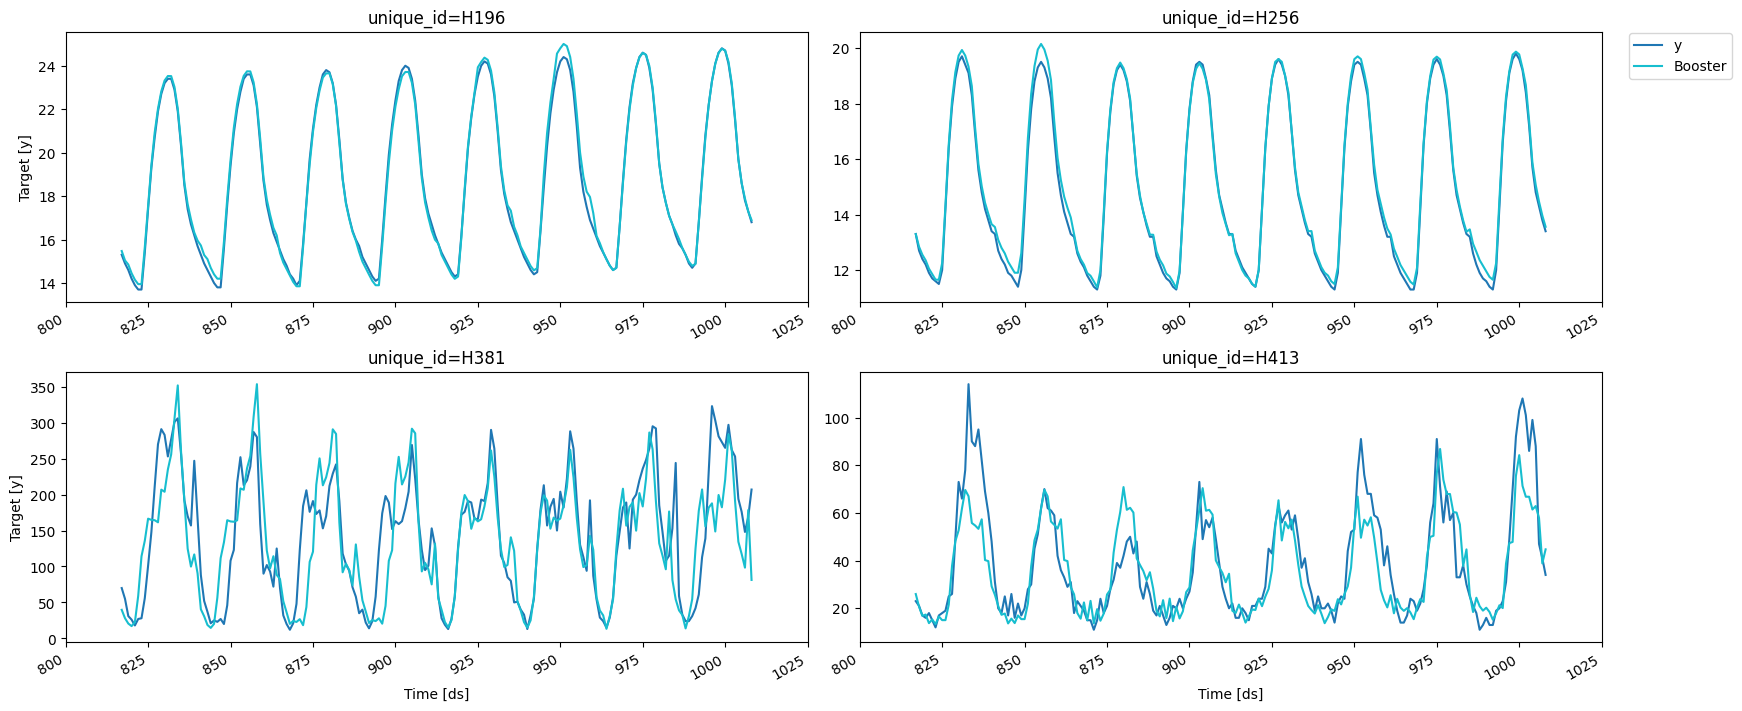

In [87]:
fig = plot_series(forecasts_df = cv.cv_preds_.drop(columns = "window"))
fig

### final model

In [89]:
# final model
final_fcst = MLForecast.from_cv(cv)
final_fcst.fit(df)
preds = final_fcst.predict(h = 48)
preds

,unique_id,ds,LGBMRegressor
0,H196,1009,16.489676
1,H196,1010,16.152974
2,H196,1011,16.201157
3,H196,1012,15.901157
4,H196,1013,15.501157
...,...,...,...
187,H413,1052,91.846315
188,H413,1053,79.938155
189,H413,1054,46.025547
190,H413,1055,44.125028


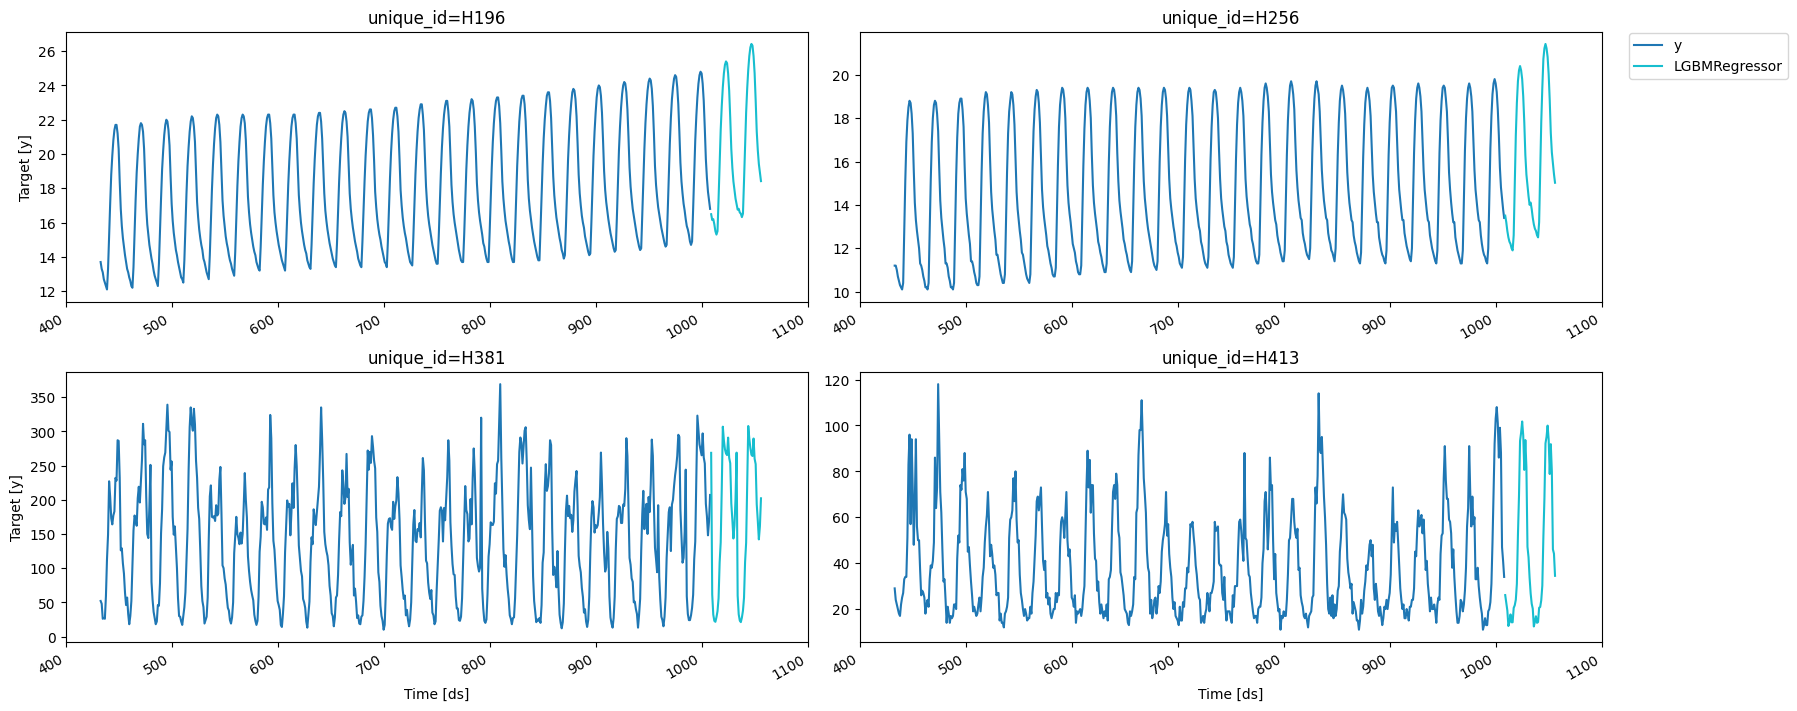

In [90]:
fig = plot_series(df, preds, max_insample_length = 24 * 24)
fig